# *PROPHET STOCK PREDICTION TESLA*

# Libraries

In [1]:
!pip install yfinance prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 928.0/928.0 kB 25.2 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for peewee: filename=peewee-3.16.3-cp310-cp310-linux_x86_64.whl size=314460 sha256=26c54e7247f61f75c97eda796fad5e6102dd24e9b7b32490108e6df91c5ce5a0
  Stored in directory: /root/.cache/pip/wheels/c8/ac/6d/ad6d828725ffbe3abc508c95d25dd0c5fcc63539ae47913790
Successfully built peewee


In [2]:
import yfinance as yf

from prophet import Prophet

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Loading and Preparing Data

In [3]:
start_date = "2018-01-02"

train_end_date = "2023-05-01"


end_data = "2023-10-01"

In [4]:
ticker_list = ["TSLA", "CL", "TNK", "002460.SZ", "VTI"]

data = yf.download(ticker_list, start = start_date, end = end_data)[["Close"]]
data.head()

[*********************100%%**********************]  5 of 5 completed


Close                                         
            002460.SZ         CL    TNK       TSLA         VTI
Date                                                          
2018-01-02  33.857143  75.139999  11.12  21.368668  138.220001
2018-01-03  35.176189  74.849998  11.12  21.150000  139.020004
2018-01-04  35.204762  75.330002  11.12  20.974667  139.550003
2018-01-05  34.238094  75.419998  10.80  21.105333  140.369995
2018-01-08  34.423809  75.529999  10.40  22.427334  140.690002

In [5]:
data.columns = data.columns.droplevel(0)

data.head()

,002460.SZ,CL,TNK,TSLA,VTI
Date,,,,,
2018-01-02,33.857143,75.139999,11.12,21.368668,138.220001
2018-01-03,35.176189,74.849998,11.12,21.150000,139.020004
2018-01-04,35.204762,75.330002,11.12,20.974667,139.550003
2018-01-05,34.238094,75.419998,10.80,21.105333,140.369995
2018-01-08,34.423809,75.529999,10.40,22.427334,140.690002


In [6]:
data = data.fillna(method='ffill')


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1493 entries, 2018-01-02 to 2023-09-29
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   002460.SZ  1493 non-null   float64
 1   CL         1493 non-null   float64
 2   TNK        1493 non-null   float64
 3   TSLA       1493 non-null   float64
 4   VTI        1493 non-null   float64
dtypes: float64(5)
memory usage: 70.0 KB


# Visualize the Data

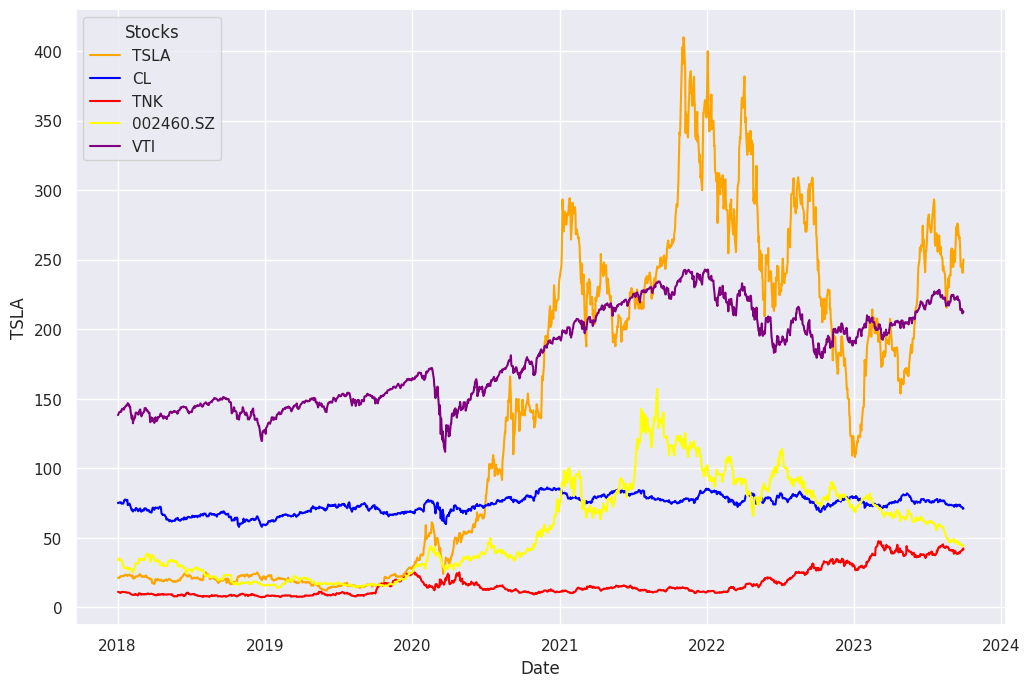

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called 'data' with columns "OXY", "CL", and "BRK-B"

sns.set(rc={"figure.figsize": (12, 8)})
sns.lineplot(x=data.index, y=data["TSLA"], label="TSLA", color ="orange")
sns.lineplot(x=data.index, y=data["CL"], label="CL", color ="blue")
sns.lineplot(x=data.index, y=data["TNK"], label="TNK", color ="red")
sns.lineplot(x=data.index, y=data["002460.SZ"], label="002460.SZ", color ="yellow")
sns.lineplot(x=data.index, y=data["VTI"], label="VTI", color ="purple")

# Customize the legend
plt.legend(title="Stocks", loc="upper left")

plt.show()


In [9]:
data = data.reset_index()
data.head()

,Date,002460.SZ,CL,TNK,TSLA,VTI
0,2018-01-02,33.857143,75.139999,11.12,21.368668,138.220001
1,2018-01-03,35.176189,74.849998,11.12,21.150000,139.020004
2,2018-01-04,35.204762,75.330002,11.12,20.974667,139.550003
3,2018-01-05,34.238094,75.419998,10.80,21.105333,140.369995
4,2018-01-08,34.423809,75.529999,10.40,22.427334,140.690002


In [10]:
data.columns = ["ds", "002460.SZ", "CL", "TNK", "y", "VTI"]

In [11]:
data.head()

,ds,002460.SZ,CL,TNK,y,VTI
0,2018-01-02,33.857143,75.139999,11.12,21.368668,138.220001
1,2018-01-03,35.176189,74.849998,11.12,21.150000,139.020004
2,2018-01-04,35.204762,75.330002,11.12,20.974667,139.550003
3,2018-01-05,34.238094,75.419998,10.80,21.105333,140.369995
4,2018-01-08,34.423809,75.529999,10.40,22.427334,140.690002


# Splitting the data

In [12]:
train = data[data["ds"] <= train_end_date]
test = data[data["ds"] > train_end_date]

print(train.shape)
print(test.shape)

(1384, 6)
(109, 6)


# Prediction Function

In [13]:

def prediction(model, periods=30, columns_to_merge=None):

    # Create the future dataframe using the Prophet model
    future_model= model.make_future_dataframe(periods = periods)

    # Merge selected columns from the original data
    if columns_to_merge:
        future_model = pd.merge(future_model, data[columns_to_merge], on='ds', how='inner')

    # Fill NaN values using forward fill (ffill)
    future_model = future_model.fillna(method='ffill')

    forecast_model = model.predict(future_model)

    model_baseline.plot(forecast_model);

    model_baseline.plot_components(forecast_model);

    return forecast_model


# Eval Metric Function

In [14]:
def eval(test, forecast_df):
  performance = pd.merge(test, forecast_df[["ds", 'yhat', 'yhat_lower', 'yhat_upper']][-30:], on = "ds")

  performance_mae = mean_absolute_error(performance['y'], performance['yhat'])

  performance_mape = mean_absolute_percentage_error(performance['y'], performance['yhat'])

  return {"MAE": performance_mae,
          "MAPE": performance_mape}


# BASELINE MODEL

## Train Baseline Model

In [15]:
model_baseline = Prophet()

model_baseline.fit(train)

15:02:17 - cmdstanpy - INFO - Chain [1] start processing
15:02:17 - cmdstanpy - INFO - Chain [1] done processing


## Prediction 30 days Baseline Model

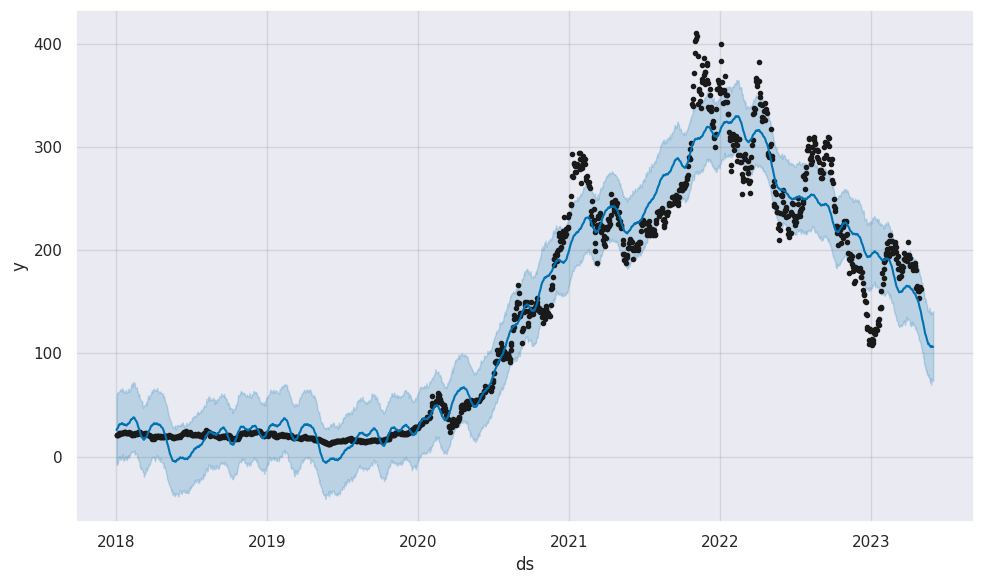

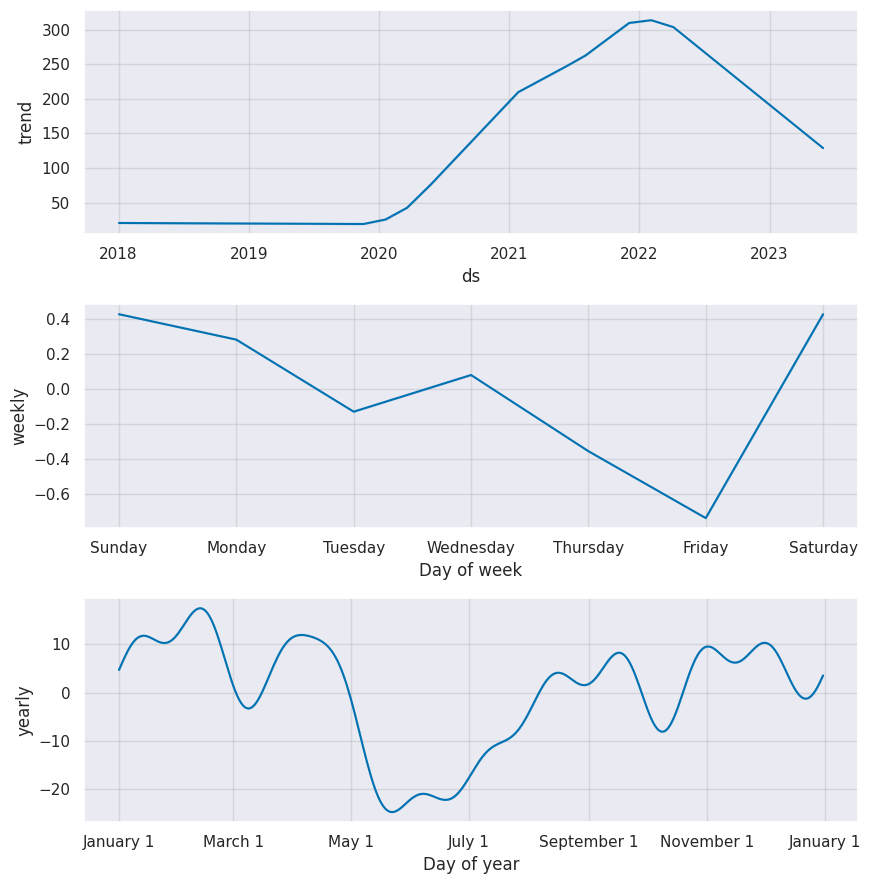

In [16]:
forecast_baseline = prediction(model = model_baseline, periods = 30);

## Eval Baseline Model

In [17]:
eval_baseline = eval(test, forecast_baseline)
eval_baseline

{'MAE': 60.50942366920351, 'MAPE': 0.33470323044373035}

# Season Model

## Train Season Model

In [18]:
model_season = Prophet(yearly_seasonality = True, weekly_seasonality = True)

model_season.fit(train)

15:02:20 - cmdstanpy - INFO - Chain [1] start processing
15:02:20 - cmdstanpy - INFO - Chain [1] done processing


## Prediction 30 days Season Model

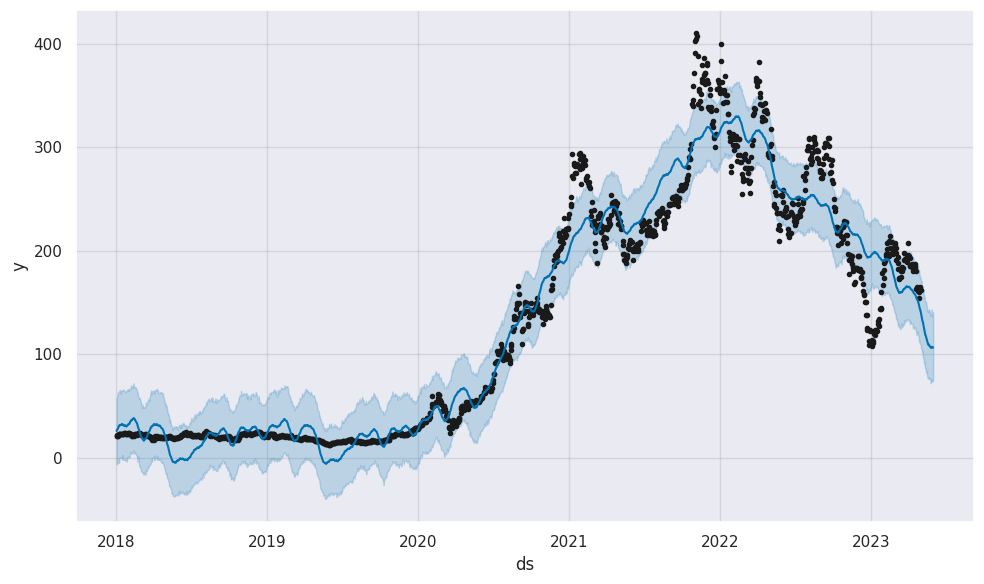

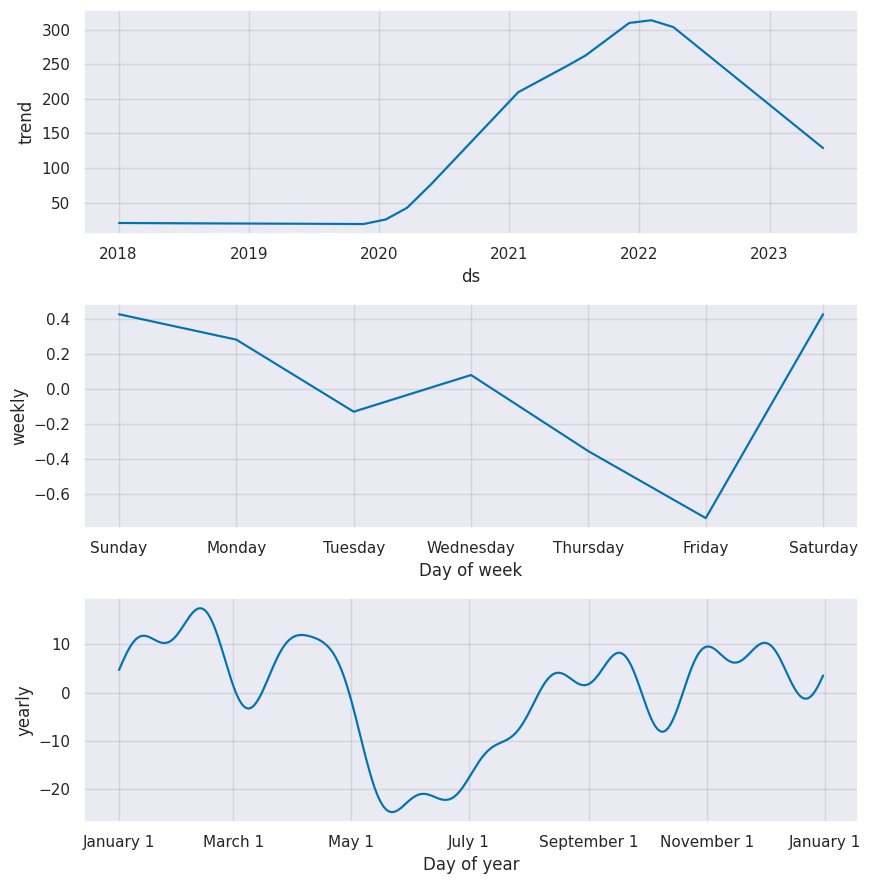

In [19]:
forecast_season = prediction(model = model_season, periods = 30);

## Eval Season Model

In [20]:
eval_season = eval(test, forecast_season)
eval_season

{'MAE': 60.50942366920351, 'MAPE': 0.33470323044373035}

# Multivariate Model 1

## Train Multivariate Model 1

In [21]:
model_multivariate_1 = Prophet(yearly_seasonality = True, weekly_seasonality = True)

model_multivariate_1.add_regressor("CL", standardize = False)

model_multivariate_1.fit(train)

15:02:23 - cmdstanpy - INFO - Chain [1] start processing
15:02:24 - cmdstanpy - INFO - Chain [1] done processing


## Prediction 30 days Multivariate Model 1

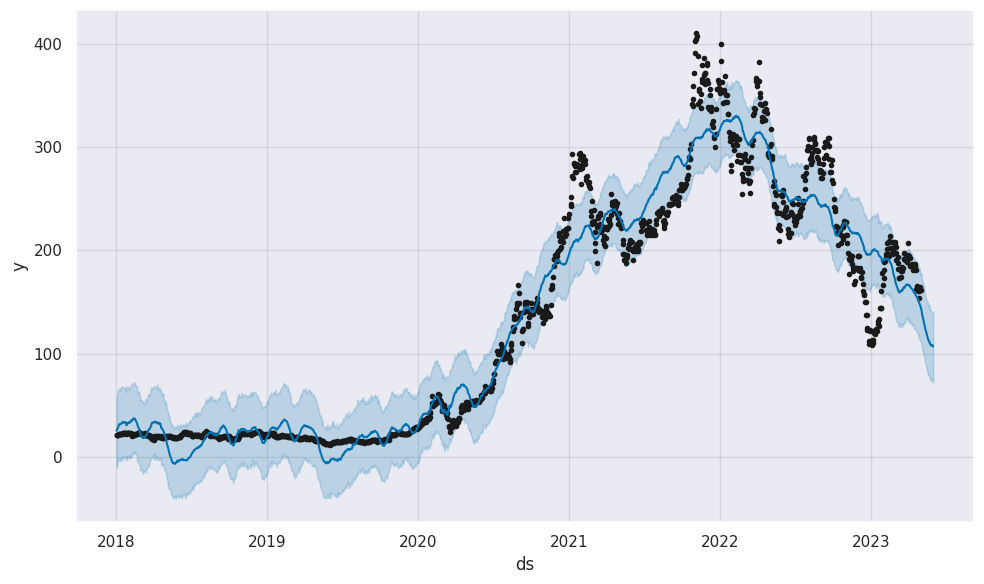

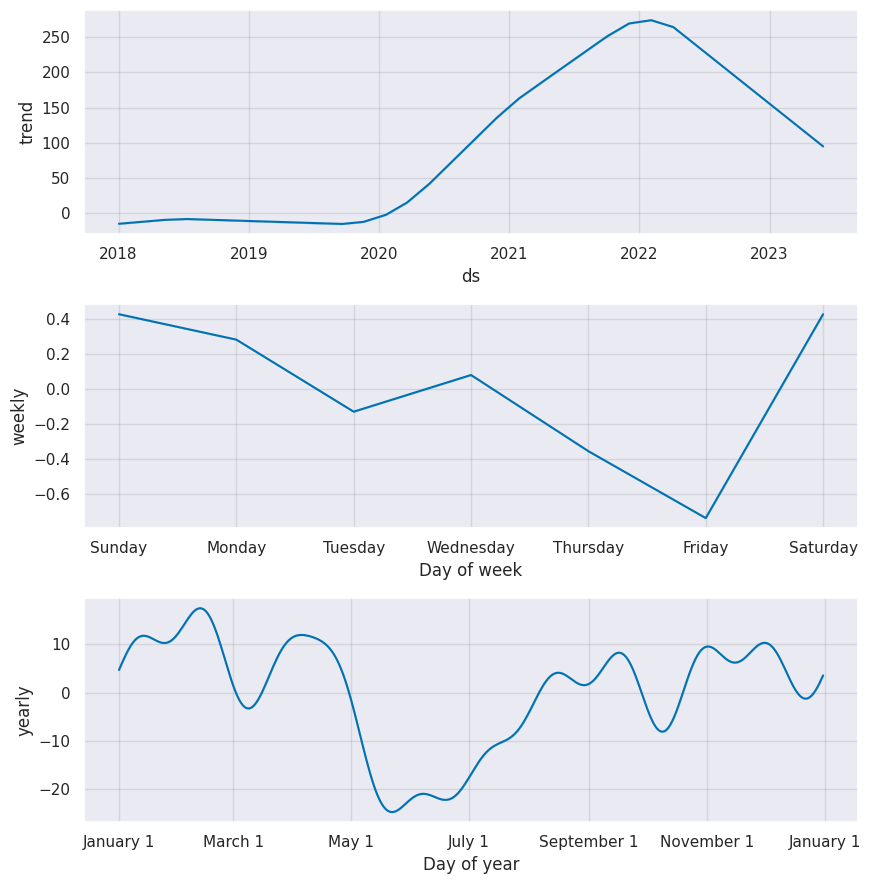

In [22]:
forecast_multivariate_1 = prediction(model = model_multivariate_1, periods = 30, columns_to_merge = ["ds", "CL"]);

## Eval Multivariate Model 1

In [23]:
eval_multivariate_1 = eval(test, forecast_multivariate_1)
eval_multivariate_1

{'MAE': 56.67604609393024, 'MAPE': 0.31244524153354036}

# Multivariate Model 2

In [24]:
model_multivariate_2 = Prophet(yearly_seasonality = True, weekly_seasonality = True)

model_multivariate_2.add_regressor("CL", standardize = False)
model_multivariate_2.add_regressor("VTI", standardize = False)

model_multivariate_2.fit(train)



15:02:27 - cmdstanpy - INFO - Chain [1] start processing
15:02:28 - cmdstanpy - INFO - Chain [1] done processing


## Prediction 30 days Multivariate Model 2

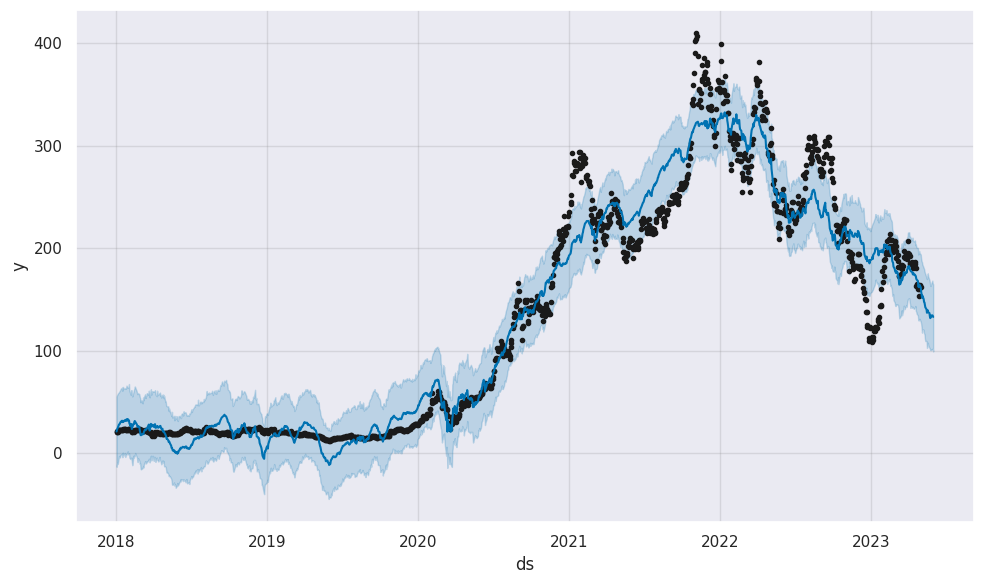

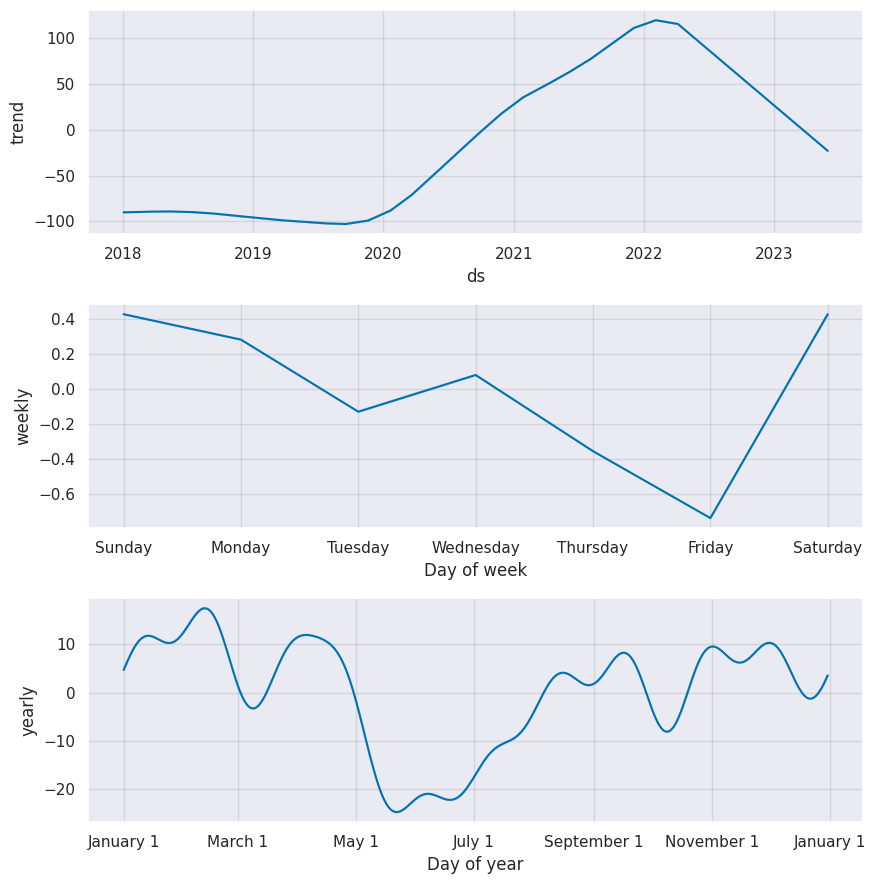

In [25]:
forecast_multivariate_2 = prediction(model = model_multivariate_2, periods = 30, columns_to_merge = ["ds", "CL","VTI"]);

## Eval Multivariate Model 2

In [26]:
eval_multivariate_2 = eval(test, forecast_multivariate_2)
eval_multivariate_2

{'MAE': 35.623302841832356, 'MAPE': 0.19458583043176647}

# Mulitvariate Model 3

## Prediction 30 days Multivariate Model 3

In [27]:
model_multivariate_3 = Prophet(yearly_seasonality = True, weekly_seasonality = True)

model_multivariate_3.add_regressor("CL", standardize = False)
model_multivariate_3.add_regressor("TNK", standardize = False)
model_multivariate_3.add_regressor("VTI", standardize = False)

model_multivariate_3.fit(train)

15:02:31 - cmdstanpy - INFO - Chain [1] start processing
15:02:34 - cmdstanpy - INFO - Chain [1] done processing


## Prediction 30 days Multivariate Model 3

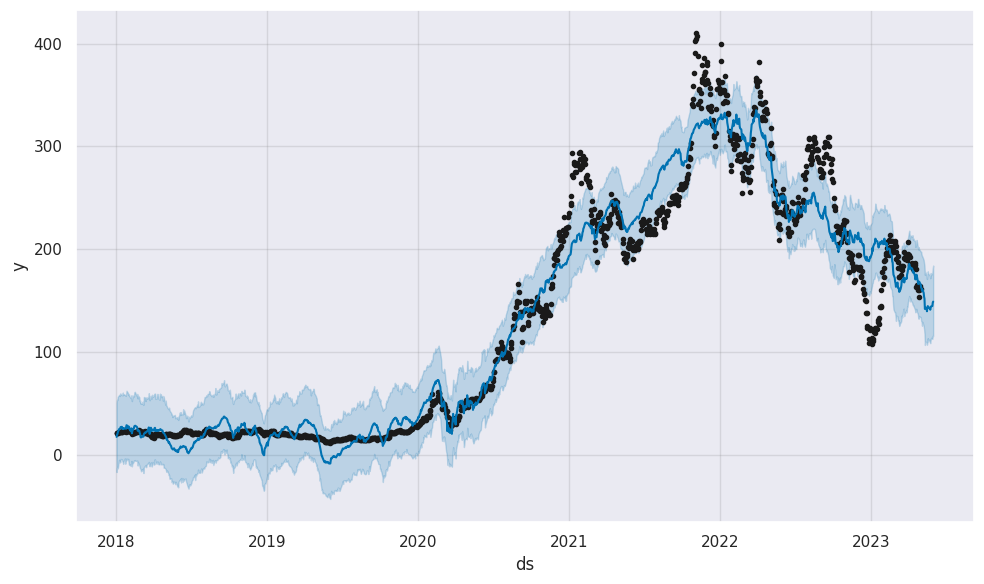

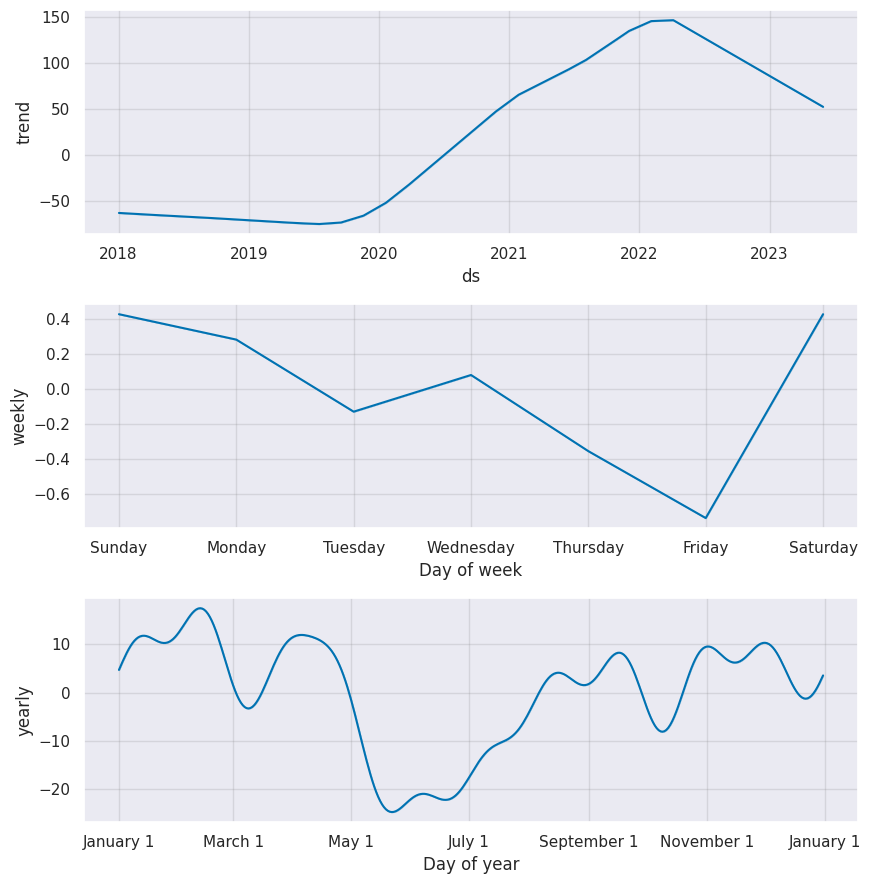

In [28]:
forecast_multivariate_3 = prediction(model = model_multivariate_3, periods = 30, columns_to_merge = ["ds", "CL", "TNK", "VTI"]);

## Eval Multivariate Model 3

In [29]:
eval_multivariate_3 = eval(test, forecast_multivariate_3)
eval_multivariate_3

{'MAE': 29.180389196626063, 'MAPE': 0.15935174877832867}

In [30]:
eval_multivariate_3, eval_multivariate_2, eval_multivariate_1, eval_season, eval_baseline

({'MAE': 29.180389196626063, 'MAPE': 0.15935174877832867},
 {'MAE': 35.623302841832356, 'MAPE': 0.19458583043176647},
 {'MAE': 56.67604609393024, 'MAPE': 0.31244524153354036},
 {'MAE': 60.50942366920351, 'MAPE': 0.33470323044373035},
 {'MAE': 60.50942366920351, 'MAPE': 0.33470323044373035})

In [58]:
COVID = pd.DataFrame({
    'holiday' : 'COVID',
    'ds' : pd.to_datetime(['2020-03-15']),
    'lower_window' : -15,
    'upper_window' : 100
})

Ukraine_Russia_War = pd.DataFrame({
    'holiday' : 'Ukraine_Russia_War',
    'ds' : pd.to_datetime(['2022-02-24']),
    'lower_window' : -5,
    'upper_window' : 100,
})


Twitter = pd.DataFrame({
    'holiday' : 'Twitter',
    'ds' : pd.to_datetime(['2022-04-14']),
    'lower_window' : -5,
    'upper_window' : 15
})


IRA = pd.DataFrame({
    'holiday' : 'IRA',
    'ds' : pd.to_datetime(['2022-08-16']),
    'lower_window' : -5,
    'upper_window' : 15
})


events = pd.concat((COVID,Ukraine_Russia_War, Twitter, IRA))

events

,holiday,ds,lower_window,upper_window
0,COVID,2020-03-15,-15,100
0,Ukraine_Russia_War,2022-02-24,-5,100
0,Twitter,2022-04-14,-5,200
0,IRA,2022-08-16,-5,15


# Holiday Model

In [59]:
model_holiday = Prophet(yearly_seasonality = True, weekly_seasonality=True, holidays=events)
model_holiday.add_country_holidays(country_name = "US")

model_holiday.fit(train)

15:04:52 - cmdstanpy - INFO - Chain [1] start processing
15:04:56 - cmdstanpy - INFO - Chain [1] done processing


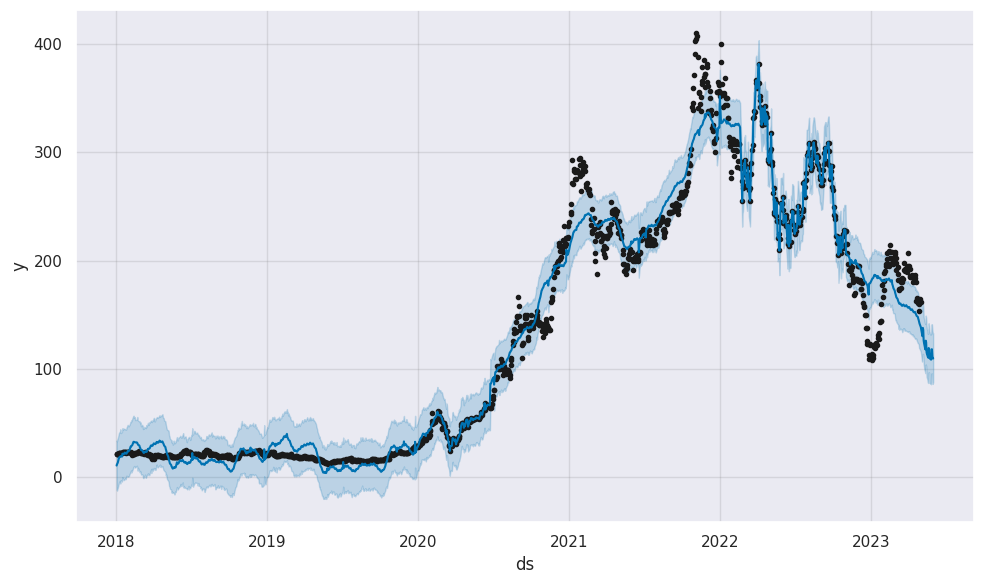

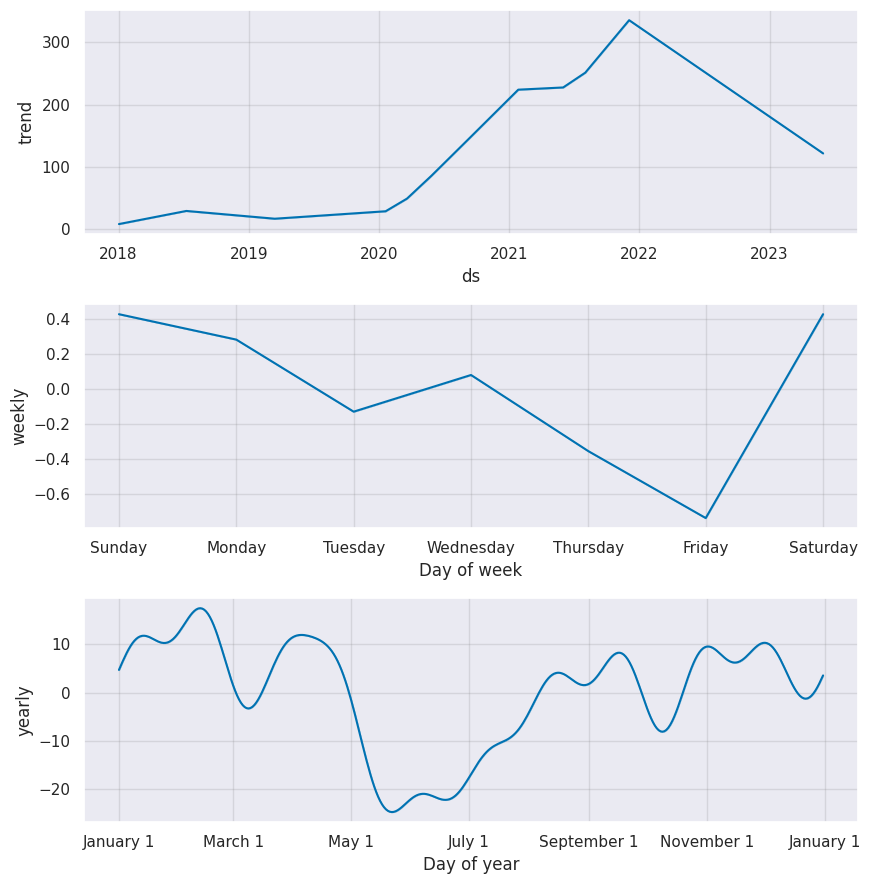

In [60]:
forecast_holiday = prediction(model = model_holiday, periods = 30, columns_to_merge = None)

In [61]:
holiday_model = eval(test, forecast_holiday)

# Holiday and Multivariate Model

In [62]:
model_multi_holiday = Prophet(yearly_seasonality = True, weekly_seasonality=True, holidays=events)

model_multi_holiday.add_country_holidays(country_name = "US")

model_multi_holiday.add_regressor("CL", standardize = False)
model_multi_holiday.add_regressor("TNK", standardize = False)


model_multi_holiday.fit(train)

15:05:00 - cmdstanpy - INFO - Chain [1] start processing
15:05:07 - cmdstanpy - INFO - Chain [1] done processing


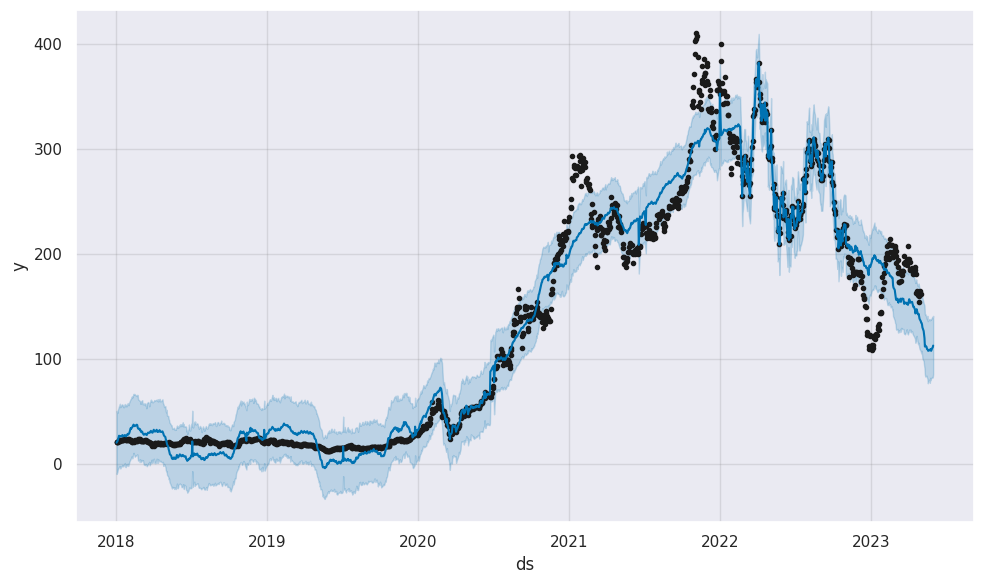

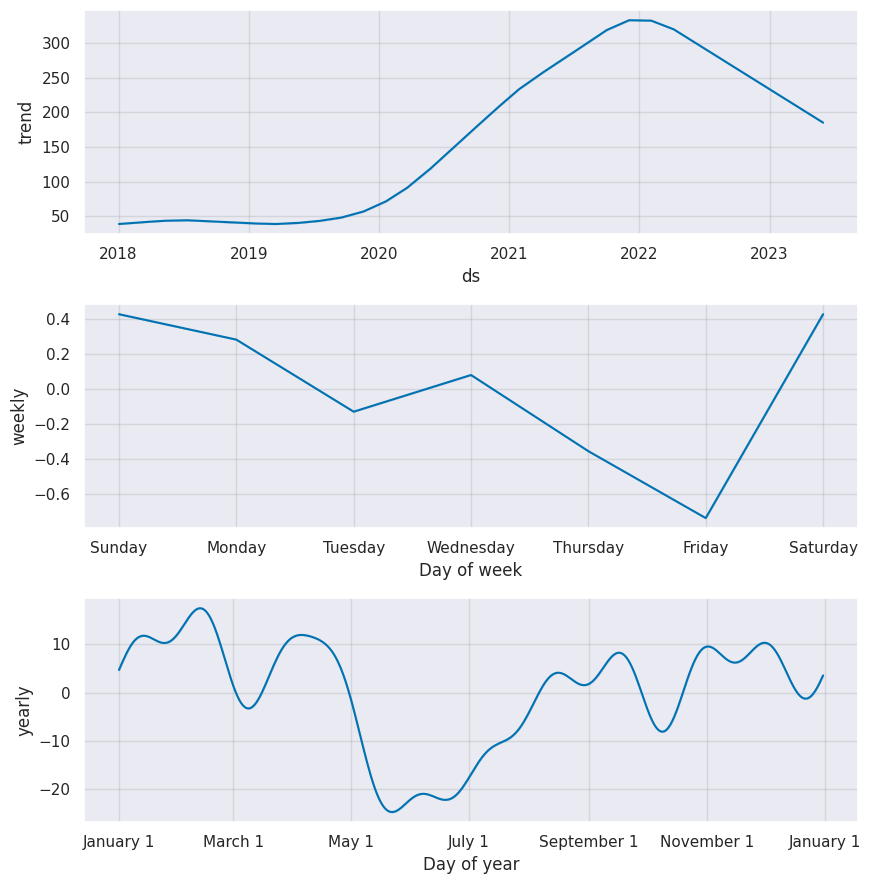

In [63]:
forecast_multi_holiday = prediction(model = model_multi_holiday, periods = 30, columns_to_merge = [ "CL", "TNK","ds", "VTI"])

In [64]:
holiday_multi_model = eval(test, forecast_multi_holiday)

In [65]:
print(f" Multivarialbe Model (CL, TNK, VTI) with holidays and events: {holiday_multi_model} \n, Holiday only Model:{holiday_model}\n, Multivarialbe Model (CL, TNK, VTI): {eval_multivariate_3} \n, Multivarialbe Model (CL, VTI): {eval_multivariate_2} \n, Multivarialbe Model (CL): {eval_multivariate_1} \n, Basic Model with Seasonality: {eval_season} \n, Basic Model: {eval_baseline}")

 Multivarialbe Model (CL, TNK, VTI) with holidays and events: {'MAE': 61.3737462669682, 'MAPE': 0.3406833055650091} 
, Holiday only Model:{'MAE': 59.76453491599728, 'MAPE': 0.3311901004642478}
, Multivarialbe Model (CL, TNK, VTI): {'MAE': 29.180389196626063, 'MAPE': 0.15935174877832867} 
, Multivarialbe Model (CL, VTI): {'MAE': 35.623302841832356, 'MAPE': 0.19458583043176647} 
, Multivarialbe Model (CL): {'MAE': 56.67604609393024, 'MAPE': 0.31244524153354036} 
, Basic Model with Seasonality: {'MAE': 60.50942366920351, 'MAPE': 0.33470323044373035} 
, Basic Model: {'MAE': 60.50942366920351, 'MAPE': 0.33470323044373035}


In [66]:
eval_multivariate_3

{'MAE': 29.180389196626063, 'MAPE': 0.15935174877832867}